# Setup

In [42]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
%pip install fairlearn
from fairlearn.metrics import (
    MetricFrame, false_positive_rate, false_negative_rate, false_negative_rate_difference,
    false_positive_rate_difference, demographic_parity_ratio, equalized_odds_ratio, selection_rate_difference)
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.


In [3]:
# read in data
df_train = pd.read_csv("data/train.csv")
df_songs = pd.read_csv("data/songs.csv")
df_artists = pd.read_csv("data/artists.csv")

df_artists.rename(columns={"gender": "artist_gender"}, inplace=True)
df_artists.rename(columns={"country": "artist_country"}, inplace=True)

In [4]:
# merge data together
seeds = [85, 25, 121, 61, 73, 37, 97, 49, 109, 13]
popularity_tresholds = [100, 1000]
popularity_func = lambda x: 'high' if x >= popularity_tresholds[1] else 'medium' if x >= popularity_tresholds[0] else 'low'

df_info = df_train.merge(df_songs, on="song_id", how="left")
df_info = df_info.merge(df_artists, on="artist_name", how="left")
artist_listeners = df_info.groupby('artist_name')['msno'].nunique()
df_info['artist_listeners'] = df_info['artist_name'].map(artist_listeners)
df_info['artist_popularity'] = df_info['artist_listeners'].apply(popularity_func)

merged_dfs = []

for seed in seeds:
    predictions = pd.read_csv(f"data/predictions/final/final_seed{seed}.csv")
    df_merged = predictions.merge(df_info, on=["song_id", "msno"], how="left")
    df_merged['prediction'] = df_merged['probability'] >= 0.5
    merged_dfs.append(df_merged)

# Overall Performance

In [5]:
performance_metrics = {
    "Accuracy": accuracy_score,
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=np.nan),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=np.nan),
    "FNR": false_negative_rate,
    "FPR": false_positive_rate,
}

def get_performance_metrics(y_true, y_pred):
    return {name: func(y_true, y_pred) for name, func in performance_metrics.items()}

def get_fairness_metrics(y_true, y_pred, sensitive_features):
    fnr_difference = false_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fpr_difference = false_positive_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    dpr = demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    eor = equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    sr_difference = selection_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)

    return {
        'FNR Difference': fnr_difference,
        'FPR Difference': fpr_difference,
        'Demographic Parity Ratio': dpr,
        'Equalized Odds Ratio': eor,
        'Selection Rate Difference': sr_difference
    }

In [43]:
# Get performance metrics
rows = []

for df in merged_dfs:
    y_pred = df["prediction"]
    y_true = df["target"]
    y_proba = df["probability"]

    row = {name: func(y_true, y_pred) for name, func in performance_metrics.items()}
    # Add AUC (requires probabilities)
    row["AUC"] = roc_auc_score(y_true, y_proba)
    rows.append(row)

df_performance_metrics = pd.DataFrame(rows)
df_performance_metrics

,Accuracy,Precision,Recall,FNR,FPR,AUC
0,0.765222,0.775116,0.754591,0.245409,0.223906,0.847029
1,0.766371,0.776813,0.754797,0.245203,0.221792,0.847927
2,0.765735,0.776692,0.753244,0.246756,0.221490,0.847377
3,0.765873,0.776507,0.753952,0.246048,0.221934,0.847568
4,0.765625,0.776225,0.753759,0.246241,0.222238,0.847337
5,0.766197,0.777379,0.753323,0.246677,0.220637,0.848023
6,0.765919,0.776709,0.753725,0.246275,0.221610,0.847664
7,0.766405,0.776757,0.754989,0.245011,0.221920,0.848185
8,0.766265,0.777363,0.753540,0.246460,0.220720,0.847848
9,0.767076,0.777753,0.755104,0.244896,0.220680,0.848872


In [103]:
# Average performance metrics
df_performance_metrics.std()

Accuracy     0.000512
Precision    0.000729
Recall       0.000703
FNR          0.000703
FPR          0.000969
AUC          0.000519
dtype: float64

# Artist Gender Metrics

In [45]:
gender_filtered_dfs = []
analysis_genders = ['Male', 'Female'] # filter out missing values, and genders with low counts (non-binary, not applicable, etc.)

for df in merged_dfs:
    filtered_df = df[df['artist_gender'].isin(analysis_genders)].copy()
    gender_filtered_dfs.append(filtered_df)

In [9]:
# Proportion of total listens by gender
df_info_gender_filtered = df_info[df_info['artist_gender'].isin(analysis_genders)]
df_info_gender_filtered['artist_gender'].value_counts(normalize=True)

artist_gender
Male      0.543741
Female    0.456259
Name: proportion, dtype: float64

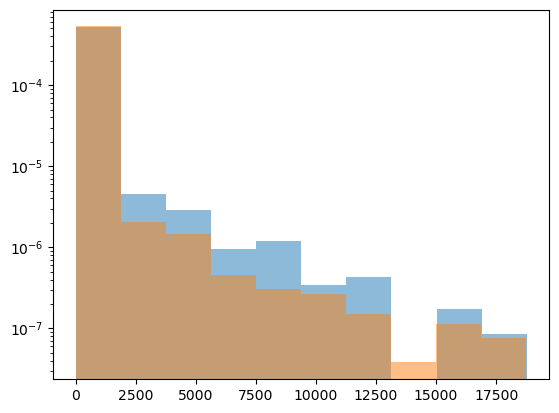

In [10]:
# Number of unique listeners by gender
male_listeners = df_artists[df_artists['artist_gender'] == 'Male']['artist_name'].map(artist_listeners)
female_listeners = df_artists[df_artists['artist_gender'] == 'Female']['artist_name'].map(artist_listeners)

plt.hist(female_listeners, density=True, alpha=0.5)
plt.hist(male_listeners, density=True, alpha=0.5)

plt.yscale('log')

In [11]:
# average number of listeners by gender
print(male_listeners.mean())
print(female_listeners.mean())

85.35688945650631
157.87287045965928


In [12]:
# proportion of artists by gender
df_artists[df_artists['artist_gender'].isin(analysis_genders)]['artist_gender'].value_counts(normalize=True)

artist_gender
Male      0.693739
Female    0.306261
Name: proportion, dtype: float64

In [13]:
# Proportion of positive predictions by gender
counts_list = []

for df in gender_filtered_dfs:
    counts = df[df['prediction'] == 1].groupby('artist_gender').size()
    counts_list.append(counts)

average = pd.concat(counts_list, axis=1).mean(axis=1)

percent = (average / average.sum()) * 100
print(percent)

artist_gender
Female    44.65228
Male      55.34772
dtype: float64


In [14]:
# Proportion of negative predictions by gender
counts_list = []

for df in gender_filtered_dfs:
    counts = df[df['prediction'] == 0].groupby('artist_gender').size()
    counts_list.append(counts)

average = pd.concat(counts_list, axis=1).mean(axis=1)

percent = (average / average.sum()) * 100
print(percent)

artist_gender
Female    46.55983
Male      53.44017
dtype: float64


In [15]:
# Within gender, proportion of positive predictions
value_counts_list = []

for df in gender_filtered_dfs:
    value_counts = df.groupby('artist_gender')['prediction'].value_counts(normalize=True)
    value_counts_list.append(value_counts)

average_value_counts = pd.concat(value_counts_list, axis=1).mean(axis=1)
average_value_counts

artist_gender  prediction
Female         False         0.513169
               True          0.486831
Male           True          0.506054
               False         0.493946
dtype: float64

In [48]:
# Performance Metrics
gender_metric_frames = []
auc_values = []

for df in gender_filtered_dfs:
    metric_frame = MetricFrame(
        metrics=performance_metrics,
        y_true=df['target'],
        y_pred=df['prediction'],
        sensitive_features=df['artist_gender']
    )
    gender_metric_frames.append(metric_frame)

    for gender in analysis_genders:
        df_gender = df[df['artist_gender'] == gender]
        if len(df_gender) > 0:
            auc = roc_auc_score(df_gender['target'], df_gender['probability'])
            auc_values.append(auc)
        else:
            auc_values.append(np.nan)

by_genders = pd.concat([gmf.by_group for gmf in gender_metric_frames])
by_genders['AUC'] = auc_values
by_genders

KeyboardInterrupt: 

In [17]:
# Average metrics by gender
by_gender_averages = by_genders.groupby('artist_gender').mean()
by_gender_averages

,Accuracy,Precision,Recall,FNR,FPR
artist_gender,,,,,
Female,0.762354,0.771622,0.748136,0.251864,0.223308
Male,0.768591,0.782634,0.765376,0.234624,0.227962


In [18]:
# Fairness metrics
gender_fairness_metrics = []

for df in gender_filtered_dfs:
    gender_fairness_metrics.append(get_fairness_metrics(df['target'], df['prediction'], df['artist_gender']))

In [19]:
df_gender_fairness_metrics = pd.DataFrame(gender_fairness_metrics)
df_gender_fairness_metrics

,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
0,0.017565,0.005379,0.960614,0.976609,0.019998
1,0.017474,0.005619,0.961341,0.975448,0.019593
2,0.018751,0.005246,0.958778,0.975473,0.020848
3,0.017508,0.003998,0.962172,0.977116,0.019142
4,0.016158,0.003126,0.964314,0.978873,0.018044
5,0.016273,0.004278,0.963813,0.978711,0.018276
6,0.016942,0.006481,0.960430,0.971592,0.020010
7,0.016199,0.004188,0.962764,0.978853,0.018854
8,0.018277,0.004368,0.962384,0.976129,0.019023
9,0.017257,0.003856,0.963539,0.977492,0.018441


In [20]:
df_gender_fairness_metrics.mean()

FNR Difference               0.017241
FPR Difference               0.004654
Demographic Parity Ratio     0.962015
Equalized Odds Ratio         0.976629
Selection Rate Difference    0.019223
dtype: float64

In [21]:
# proportion of positive predictions by artist

# Artist Popularity Metrics

In [22]:
# Proportion of positive predictions by popularity
counts_list = []

for df in merged_dfs:
    counts = df[df['prediction'] == 1].groupby('artist_popularity').size()
    counts_list.append(counts)

average = pd.concat(counts_list, axis=1).mean(axis=1)

percent = (average / average.sum()) * 100
print(percent)

artist_popularity
high      82.698373
low        4.351098
medium    12.950529
dtype: float64


In [23]:
# Within popularity, proportion of positive predictions
value_counts_list = []

for df in merged_dfs:
    value_counts = df.groupby('artist_popularity')['prediction'].value_counts(normalize=True)
    value_counts_list.append(value_counts)

average_value_counts = pd.concat(value_counts_list, axis=1).mean(axis=1)
average_value_counts

artist_popularity  prediction
high               True          0.535521
                   False         0.464479
low                False         0.704844
                   True          0.295156
medium             False         0.625102
                   True          0.374898
dtype: float64

In [24]:
# Performance Metrics
popularity_metric_frames = []

for df in merged_dfs:
    metric_frame = MetricFrame(
        metrics=performance_metrics,
        y_true=df['target'],
        y_pred=df['prediction'],
        sensitive_features=df['artist_popularity']
    )
    popularity_metric_frames.append(metric_frame)

by_popularity = pd.concat([pmf.by_group for pmf in popularity_metric_frames])
by_popularity

,Accuracy,Precision,Recall,FNR,FPR
artist_popularity,,,,,
high,0.764490,0.780361,0.780996,0.219004,0.254630
low,0.773271,0.742289,0.593785,0.406215,0.121203
medium,0.765047,0.752640,0.665367,0.334633,0.161387
high,0.765178,0.781624,0.780086,0.219914,0.252064
low,0.777547,0.752647,0.600528,0.399472,0.117270
medium,0.766959,0.754398,0.669626,0.330374,0.161110
high,0.764780,0.781107,0.779788,0.220212,0.252566
low,0.773486,0.746610,0.589049,0.410951,0.117818
medium,0.766701,0.758491,0.665018,0.334982,0.157613


In [25]:
# Average metrics by popularity
by_popularity_averages = by_popularity.groupby('artist_popularity').mean()
by_popularity_averages

,Accuracy,Precision,Recall,FNR,FPR
artist_popularity,,,,,
high,0.765193,0.781513,0.780350,0.219650,0.252339
low,0.774446,0.747093,0.593696,0.406304,0.118754
medium,0.766410,0.756156,0.665993,0.334007,0.159167


In [26]:
# Fairness metrics
popularity_fairness_metrics = []

for df in merged_dfs:
    popularity_fairness_metrics.append(get_fairness_metrics(df['target'], df['prediction'], df['artist_popularity']))

df_popularity_fairness_metrics = pd.DataFrame(popularity_fairness_metrics)
df_popularity_fairness_metrics

,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
0,0.187211,0.133427,0.551411,0.475997,0.240948
1,0.179558,0.134794,0.555623,0.465238,0.237848
2,0.190738,0.134748,0.546600,0.466485,0.242672
3,0.189148,0.133606,0.549874,0.471533,0.241203
4,0.184343,0.132531,0.555190,0.475826,0.238170
5,0.191259,0.135439,0.545675,0.462066,0.243145
6,0.183340,0.132705,0.554945,0.473361,0.238040
7,0.188157,0.134691,0.548449,0.466952,0.242115
8,0.190170,0.131799,0.550537,0.474837,0.240374
9,0.182612,0.132109,0.553258,0.473797,0.239142


In [ ]:
# Fairness metrics by popularity buckets (comparing genders within each popularity level)
popularity_fairness_by_bucket = []

for df in merged_dfs:
    # Filter to only valid genders
    df_filtered = df[df['artist_gender'].notna()].copy()
    df_filtered = df_filtered[df_filtered['artist_gender'].isin(['Male', 'Female'])]
    
    # Calculate fairness metrics for each popularity level
    for popularity in ['low', 'medium', 'high']:
        df_pop = df_filtered[df_filtered['artist_popularity'] == popularity]
        if len(df_pop) > 0 and len(df_pop['artist_gender'].unique()) > 1:
            fairness_metrics = get_fairness_metrics(df_pop['target'], df_pop['prediction'], df_pop['artist_gender'])
            fairness_metrics['artist_popularity'] = popularity
            popularity_fairness_by_bucket.append(fairness_metrics)

,FNR Difference,Selection Rate Difference
artist_popularity,,
high,0.026647,0.037523
low,0.007600,0.012058
medium,0.006732,0.007493


In [89]:
df_popularity_fairness_by_bucket = pd.DataFrame(popularity_fairness_by_bucket)
by_popularity_fairness = df_popularity_fairness_by_bucket.groupby('artist_popularity').mean()
by_popularity_fairness


,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
artist_popularity,,,,,
high,0.026647,0.017913,0.932219,0.931463,0.037523
low,0.007600,0.009935,0.959550,0.918552,0.012058
medium,0.006732,0.002587,0.980215,0.982112,0.007493


In [ ]:
df_popularity_fairness_metrics

FNR Difference               0.186654
FPR Difference               0.133585
Demographic Parity Ratio     0.551156
Equalized Odds Ratio         0.470609
Selection Rate Difference    0.240366
dtype: float64

In [ ]:
df_test = gender_filtered_dfs[0]

artist_names_with_more_than_3 = df_test['artist_name'].value_counts()[df_test['artist_name'].value_counts() > 3].index
df_sample = df_test[df_test['artist_name'].isin(artist_names_with_more_than_3)]
artist_performance_metrics = []

for artist_name in df_sample['artist_name'].unique():
    artist_gender = df_artists[df_artists['artist_name'] == artist_name]['artist_gender'].values[0]
    listeners_for_artist = artist_listeners[artist_name]
    artist_popularity = popularity_func(listeners_for_artist)

    df_artist = df_sample[df_sample['artist_name'] == artist_name]
    artist_metrics = get_performance_metrics(df_artist['target'], df_artist['prediction'])
    
    try:
        if len(df_artist['target'].unique()) > 1:
            artist_metrics['AUC'] = roc_auc_score(df_artist['target'], df_artist['probability'])
        else:
            artist_metrics['AUC'] = np.nan
    except ValueError:
        artist_metrics['AUC'] = np.nan

    artist_metrics['artist_gender'] = artist_gender
    artist_metrics['artist_popularity'] = artist_popularity

    artist_performance_metrics.append(artist_metrics)

df_artist_performance_metrics = pd.DataFrame(artist_performance_metrics)

In [50]:
df_artist_performance_metrics.describe()

,Accuracy,Precision,Recall,FNR,FPR,AUC
count,5579.000000,4768.000000,5183.000000,5579.000000,5579.000000,5117.000000
mean,0.770665,0.740901,0.568100,0.401243,0.139616,0.821658
std,0.145134,0.257646,0.303175,0.312558,0.172884,0.163985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.714286,0.666667,0.400000,0.176471,0.000000,0.770115
50%,0.774112,0.777661,0.621359,0.342657,0.100000,0.842625
75%,0.842105,1.000000,0.777778,0.571429,0.219238,0.922664
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
all_metrics = list(performance_metrics.keys()) + ['AUC']

df_artist_performance_metrics.groupby('artist_gender')[list(all_metrics)].mean()

,Accuracy,Precision,Recall,FNR,FPR,AUC
artist_gender,,,,,,
Female,0.764499,0.738568,0.571788,0.403268,0.142028,0.821210
Male,0.774274,0.742317,0.565895,0.400058,0.138204,0.821928


In [78]:
df_artist_performance_metrics.groupby(['artist_gender', 'artist_popularity'])[list(all_metrics)].mean()

df_popularity_fairness_metrics

,FNR Difference,FPR Difference,Demographic Parity Ratio,Equalized Odds Ratio,Selection Rate Difference
0,0.187211,0.133427,0.551411,0.475997,0.240948
1,0.179558,0.134794,0.555623,0.465238,0.237848
2,0.190738,0.134748,0.546600,0.466485,0.242672
3,0.189148,0.133606,0.549874,0.471533,0.241203
4,0.184343,0.132531,0.555190,0.475826,0.238170
5,0.191259,0.135439,0.545675,0.462066,0.243145
6,0.183340,0.132705,0.554945,0.473361,0.238040
7,0.188157,0.134691,0.548449,0.466952,0.242115
8,0.190170,0.131799,0.550537,0.474837,0.240374
9,0.182612,0.132109,0.553258,0.473797,0.239142


In [ ]:
# Setup for graphs
performance_metrics_list = ['Accuracy', 'Precision', 'Recall', 'FNR', 'FPR']
grouped_performance = df_artist_performance_metrics.groupby(['artist_gender', 'artist_popularity'])[performance_metrics_list].mean()

all_fairness_metrics = list(by_popularity_fairness.columns)
fairness_metrics_list = [None] * 5

if 'FNR Difference' in all_fairness_metrics:
    fairness_metrics_list[3] = 'FNR Difference'
if 'FPR Difference' in all_fairness_metrics:
    fairness_metrics_list[4] = 'FPR Difference'

other_metrics = [m for m in all_fairness_metrics if m not in ['FNR Difference', 'FPR Difference']]
for i, metric in enumerate(other_metrics[:3]):
    fairness_metrics_list[i] = metric

popularity_order = ['low', 'medium', 'high']
popularity_colors = {'low': '#FFA07A', 'medium': '#20B2AA', 'high': '#9370DB'}
gender_colors = {'Male': 'steelblue', 'Female': 'pink'}

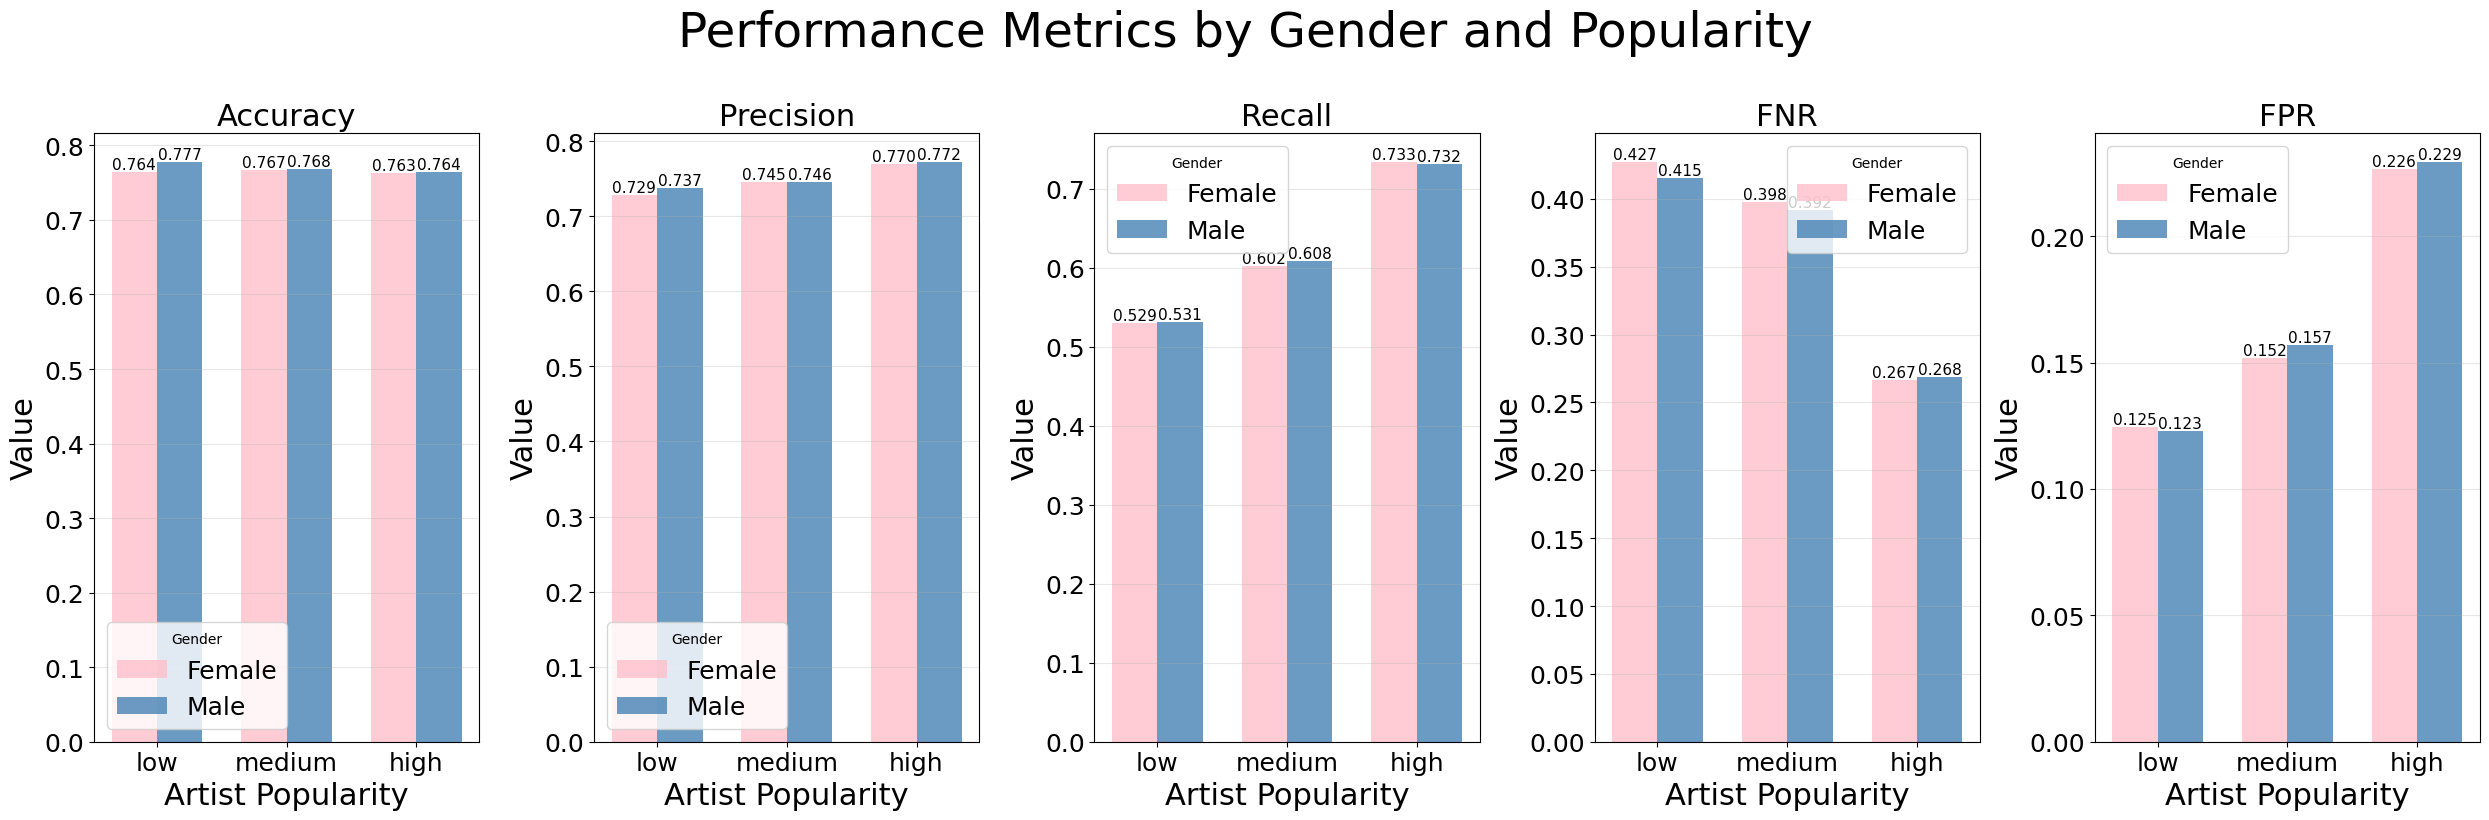

In [172]:
# Graph 1: Performance metrics by gender and popularity
fig1, axes1 = plt.subplots(1, 5, figsize=(25, 8))
axes1 = axes1.flatten()

for idx, metric in enumerate(performance_metrics_list):
    ax = axes1[idx]
    
    data = grouped_performance[metric].unstack(level='artist_gender')
    data = data.reindex([p for p in popularity_order if p in data.index])
    
    x = np.arange(len(data.index))
    width = 0.35
    positions = [x - width/2, x + width/2]
    
    bars_list = []
    for i, gender in enumerate(data.columns):
        color = gender_colors.get(gender, 'gray')
        values = pd.to_numeric(data[gender], errors='coerce')
        bars = ax.bar(positions[i], values, width, label=gender, alpha=0.8, color=color)
        bars_list.append(bars)
        
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=11)
    
    ax.set_xlabel('Artist Popularity', fontsize=22)
    ax.set_ylabel('Value', fontsize=22)
    ax.set_title(metric, fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels(data.index.tolist(), fontsize=22)
    ax.legend(title='Gender', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.grid(True, alpha=0.3, axis='y')

fig1.suptitle('Performance Metrics by Gender and Popularity', fontsize=35, y=1.02)
plt.tight_layout()
plt.show()


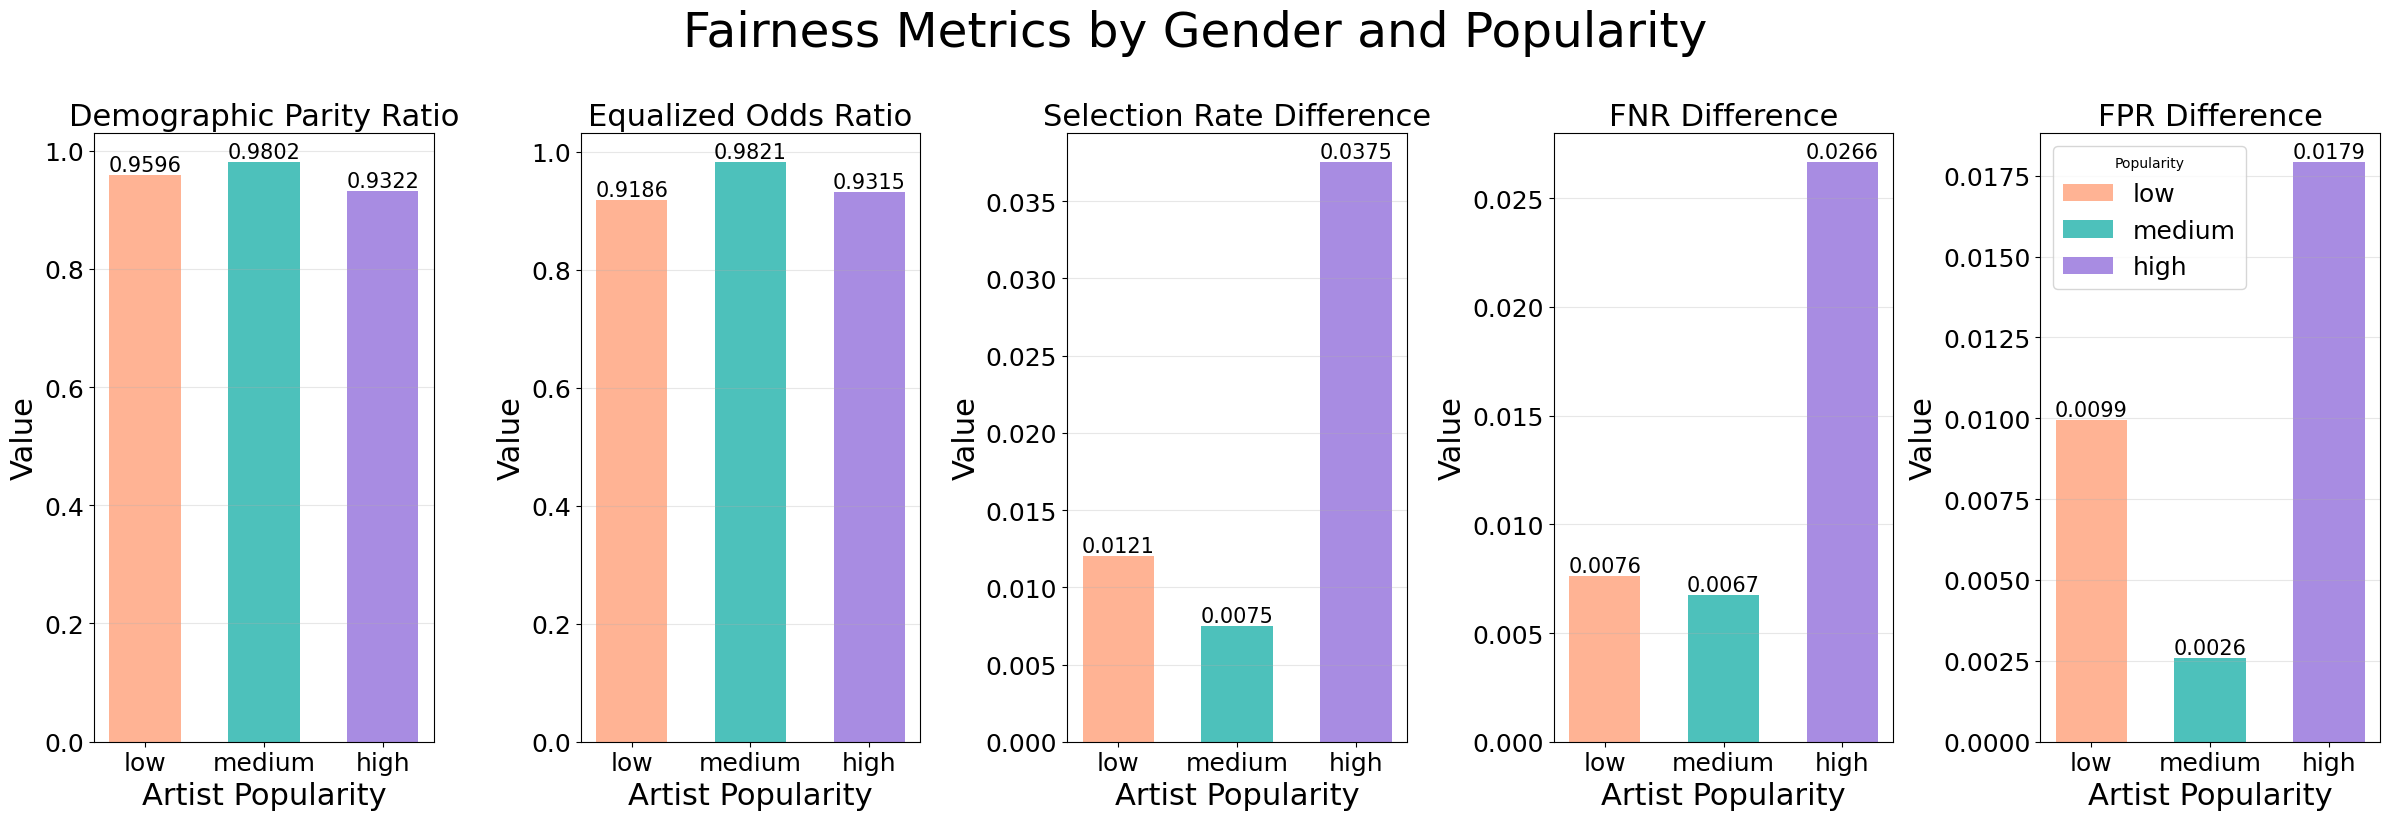

In [ ]:
# Graph 2: Fairness metrics by popularity buckets
by_popularity_fairness_ordered = by_popularity_fairness.reindex([p for p in popularity_order if p in by_popularity_fairness.index])

valid_fairness_metrics = [m for m in fairness_metrics_list if m is not None]
fig2, axes2 = plt.subplots(1, 5, figsize=(24, 8))
if len(valid_fairness_metrics) == 1:
    axes2 = [axes2]
else:
    axes2 = axes2.flatten()

for idx, metric in enumerate(fairness_metrics_list):
    if metric is None:
        continue 
    ax_idx = valid_fairness_metrics.index(metric)
    ax = axes2[ax_idx]
    
    data = by_popularity_fairness_ordered[metric]
    
    x = np.arange(len(data.index))
    width = 0.6
    
    values = pd.to_numeric(data.values, errors='coerce')
    
    bars = []
    for i, (pop_level, value) in enumerate(zip(data.index, values)):
        color = popularity_colors.get(pop_level, 'gray')
        bar = ax.bar(i, value, width, alpha=0.8, color=color, label=pop_level if ax_idx == 4 else '')
        bars.append(bar)
        
        if not np.isnan(value):
            ax.text(bar[0].get_x() + bar[0].get_width()/2., value,
                   f'{value:.4f}',
                   ha='center', va='bottom', fontsize=15)
    
    ax.set_xlabel('Artist Popularity', fontsize=22)
    ax.set_ylabel('Value', fontsize=22)
    ax.set_title(metric, fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels(data.index.tolist(), fontsize=22)
    if ax_idx == 4:
        ax.legend(title='Popularity', fontsize=18)
    ax.tick_params(labelsize=18)
    ax.grid(True, alpha=0.3, axis='y')

fig2.suptitle('Fairness Metrics by Gender and Popularity', fontsize=35, y=1.02)
plt.tight_layout()
plt.show()


In [54]:
# Compare row-level, artist-level, and member-level metrics

row_level_avg = df_performance_metrics.mean()
artist_level_avg = df_artist_performance_metrics[all_metrics].mean()

comparison_df = pd.DataFrame({
    'Row-level': row_level_avg,
    'Artist-level': artist_level_avg
})

comparison_df

,Row-level,Artist-level
Accuracy,0.766069,0.770665
Precision,0.776731,0.740901
Recall,0.754102,0.568100
FNR,0.245898,0.401243
FPR,0.221693,0.139616
AUC,0.847783,0.821658


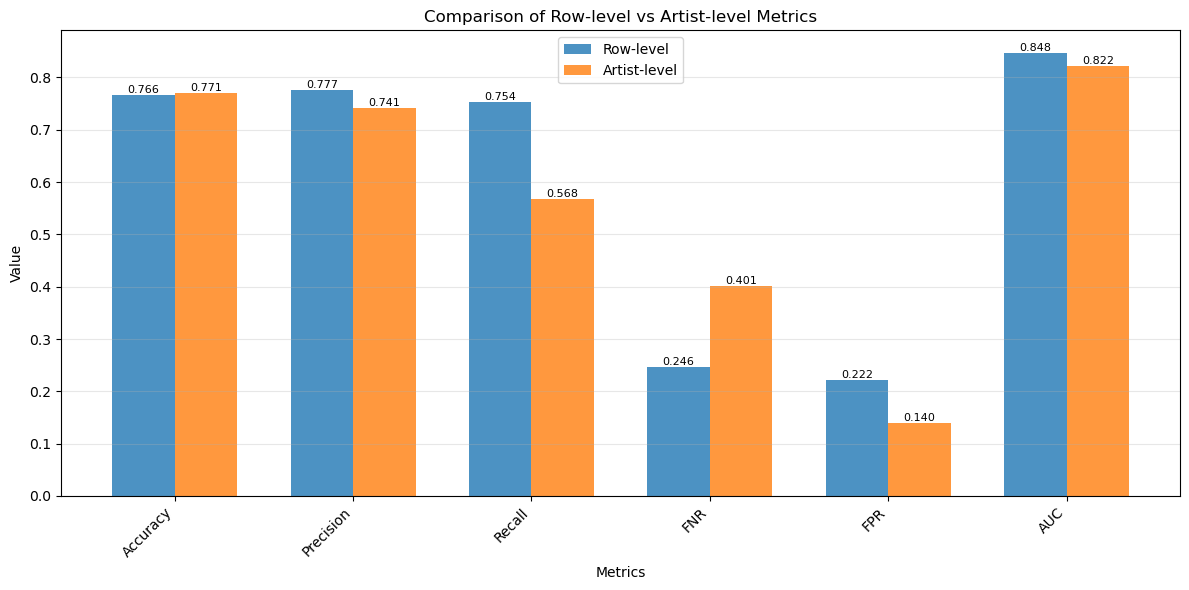

In [65]:
# Graph comparing row-level with artist-level metrics
metrics_to_compare = all_metrics

# Prepare data for plotting
x = np.arange(len(metrics_to_compare))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

row_values = [row_level_avg[metric] for metric in metrics_to_compare]
artist_values = [artist_level_avg[metric] for metric in metrics_to_compare]

bars1 = ax.bar(x - width/2, row_values, width, label='Row-level', alpha=0.8)
bars2 = ax.bar(x + width/2, artist_values, width, label='Artist-level', alpha=0.8)

# Add value labels on top of bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Label for row-level bar
    height1 = bar1.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1,
            f'{height1:.3f}',
            ha='center', va='bottom', fontsize=8)
    # Label for artist-level bar
    height2 = bar2.get_height()
    ax.text(bar2.get_x() + bar2.get_width()/2., height2,
            f'{height2:.3f}',
            ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Value')
ax.set_title('Comparison of Row-level vs Artist-level Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_compare, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [32]:
# Member-level performance
df_test = merged_dfs[0]

member_counts = df_test['msno'].value_counts()
members_with_more_than_3 = member_counts[member_counts > 3].index
df_sample_members = df_test[df_test['msno'].isin(members_with_more_than_3)]

member_performance_metrics = []

for msno in df_sample_members['msno'].unique():
    df_member = df_sample_members[df_sample_members['msno'] == msno]
    member_metrics = get_performance_metrics(df_member['target'], df_member['prediction'])
    
    member_metrics['msno'] = msno
    
    member_performance_metrics.append(member_metrics)

df_member_performance_metrics = pd.DataFrame(member_performance_metrics)
df_member_performance_metrics


,Accuracy,Precision,Recall,FNR,FPR,msno
0,0.793651,0.779661,1.000000,0.000000,0.764706,Dp/J1U1bEvNzB6OEKLtrJZSfJNedtuQh7/ZgjmZdjgM=
1,0.666667,0.500000,0.750000,0.250000,0.375000,4m5Sn66p8UPrX7DJkBD5xfdHePZEI9Nui6iDtSr5kno=
2,0.678571,0.750000,0.789474,0.210526,0.555556,/5/Mq5hPzT0Tbf0aY1CeSapADLCVz3v/II8A69Hk4Gg=
3,1.000000,NaN,NaN,0.000000,0.000000,VDdpi4A9tTo2XoHPnnMakR1p/k1dLxHL3om7Hiezq/U=
4,0.834416,0.841060,0.824675,0.175325,0.155844,lSkUSnCm60kDLdEsnAVp6jwr2HkyIhDCEZLX82djjHg=
...,...,...,...,...,...,...
24495,0.750000,0.000000,NaN,0.000000,0.250000,vWbXwAvWDcMj56oKpjh1hL2KYmLcXdWNR1nfJXVxgp4=
24496,1.000000,NaN,NaN,0.000000,0.000000,MUxOsmbvjAK6fn0OLgS2+ycpGL2IRDzaDD40Q64q+S0=
24497,1.000000,NaN,NaN,0.000000,0.000000,X6UrJS4vdmbkFX5kZ5ZChPfbO4rjSqujcehNo0rTOh0=
24498,0.800000,NaN,0.000000,1.000000,0.000000,4NsBXnfGbVwYOXTdfJi0ujhguaIJpBdRZ3Fiq9ZN0OQ=


In [33]:
# Get average metrics across all members
df_member_performance_metrics[list(performance_metrics.keys())].mean()


Accuracy     0.770609
Precision    0.735576
Recall       0.636203
FNR          0.342385
FPR          0.271088
dtype: float64

In [34]:
# Summary statistics for member-level metrics
df_member_performance_metrics[list(performance_metrics.keys())].describe()


,Accuracy,Precision,Recall,FNR,FPR
count,24500.000000,21482.000000,23058.000000,24500.000000,24500.000000
mean,0.770609,0.735576,0.636203,0.342385,0.271088
std,0.138876,0.222764,0.320099,0.322124,0.287352
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.695652,0.652174,0.433333,0.060113,0.021563
50%,0.777778,0.771429,0.717391,0.250000,0.178792
75%,0.857143,0.884615,0.909091,0.538462,0.419355
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
# Member-level performance by artist gender
# For each member, compute metrics separately for songs by male vs female artists
df_test = gender_filtered_dfs[0]  # Use gender-filtered data

member_counts = df_test['msno'].value_counts()
members_with_more_than_3 = member_counts[member_counts > 3].index
df_sample_members = df_test[df_test['msno'].isin(members_with_more_than_3)]

member_performance_metrics_by_gender = []

for msno in df_sample_members['msno'].unique():
    df_member = df_sample_members[df_sample_members['msno'] == msno]
    
    # Compute metrics for each gender separately
    for gender in analysis_genders:
        df_member_gender = df_member[df_member['artist_gender'] == gender]
        
        # Only compute if member has at least 1 interaction with this gender
        if len(df_member_gender) > 0:
            member_metrics = get_performance_metrics(df_member_gender['target'], df_member_gender['prediction'])
            member_metrics['msno'] = msno
            member_metrics['artist_gender'] = gender
            member_performance_metrics_by_gender.append(member_metrics)

df_member_performance_metrics_by_gender = pd.DataFrame(member_performance_metrics_by_gender)
df_member_performance_metrics_by_gender


,Accuracy,Precision,Recall,FNR,FPR,msno,artist_gender
0,0.800000,0.793103,1.000000,0.000000,0.857143,Dp/J1U1bEvNzB6OEKLtrJZSfJNedtuQh7/ZgjmZdjgM=,Male
1,0.809524,0.809524,1.000000,0.000000,1.000000,Dp/J1U1bEvNzB6OEKLtrJZSfJNedtuQh7/ZgjmZdjgM=,Female
2,0.750000,0.666667,0.666667,0.333333,0.200000,4m5Sn66p8UPrX7DJkBD5xfdHePZEI9Nui6iDtSr5kno=,Male
3,0.333333,0.333333,1.000000,0.000000,1.000000,4m5Sn66p8UPrX7DJkBD5xfdHePZEI9Nui6iDtSr5kno=,Female
4,0.600000,0.714286,0.714286,0.285714,0.666667,/5/Mq5hPzT0Tbf0aY1CeSapADLCVz3v/II8A69Hk4Gg=,Male
...,...,...,...,...,...,...,...
44374,0.500000,NaN,0.000000,1.000000,0.000000,PtwQ+eCwmLussislLGHfwrbaMXu8cnbuobpV+meX4zQ=,Female
44375,0.500000,NaN,0.000000,1.000000,0.000000,4NsBXnfGbVwYOXTdfJi0ujhguaIJpBdRZ3Fiq9ZN0OQ=,Male
44376,1.000000,NaN,NaN,0.000000,0.000000,4NsBXnfGbVwYOXTdfJi0ujhguaIJpBdRZ3Fiq9ZN0OQ=,Female
44377,0.666667,NaN,0.000000,1.000000,0.000000,TcMV21WiDQKf2+YQo6V0098iA6PusZzDeSPCcxU/OsQ=,Male


In [38]:
# Average member-level metrics by artist gender
df_member_performance_metrics_by_gender.groupby('artist_gender')[list(performance_metrics.keys())].mean()


,Accuracy,Precision,Recall,FNR,FPR
artist_gender,,,,,
Female,0.767323,0.739284,0.654408,0.305030,0.256980
Male,0.772157,0.749134,0.671365,0.297519,0.264463


In [40]:
# Compare member-level metrics by gender with artist-level metrics by gender
member_level_by_gender = df_member_performance_metrics_by_gender.groupby('artist_gender')[list(performance_metrics.keys())].mean()
artist_level_by_gender = df_artist_performance_metrics.groupby('artist_gender')[list(performance_metrics.keys())].mean()

comparison_by_gender = pd.DataFrame({
    'Member-level (Male artists)': member_level_by_gender.loc['Male'],
    'Artist-level (Male artists)': artist_level_by_gender.loc['Male'],
    'Member-level (Female artists)': member_level_by_gender.loc['Female'],
    'Artist-level (Female artists)': artist_level_by_gender.loc['Female']
})

comparison_by_gender


,Member-level (Male artists),Artist-level (Male artists),Member-level (Female artists),Artist-level (Female artists)
Accuracy,0.772157,0.774274,0.767323,0.764499
Precision,0.749134,0.742317,0.739284,0.738568
Recall,0.671365,0.565895,0.654408,0.571788
FNR,0.297519,0.400058,0.305030,0.403268
FPR,0.264463,0.138204,0.256980,0.142028
